# Image Classification with Fashion MNIST
> In this post, we will implement the Image classification (especially on Fashion MNIST) with Neural Network using Tensorflow.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Deep_Learning, Tensorflow-Keras]
- image: images/FashionMNIST.png

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

## Fashion MNIST
![LeNet](image/LeNet_Original_Image.jpg)
Yann LeCun introduced Convolutional Neural Network (CNN for short) through [his paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), namely **LeNet-5**, and shows its effectiveness in hand-written digits. The dataset used his paper is called ["Modified National Institute of Standards and Technology"](http://yann.lecun.com/exdb/mnist/)(or MNIST for short), and it is widely used for validating the neural network performance. 

![MNIST](image/220px-MnistExamples.png)

Each image has 28x28 shapes, and is grayscaled (meaning that each pixel value has a range from 0 to 255). But as you notice from original image, features for each digits are almost clear, so most of neural network in now can easily learn its dataset. And also the task cannot represent the complicated task. So there are many trials to formalize its baseline dataset. One of these is [Fashion-MNIST](https://www.kaggle.com/zalando-research/fashionmnist), presented by Zalando research. Its dataset also has 28x28 pixels, and has 10 labels to classify. So main properties are same as Original MNIST, but it is hard to classify it. 

![FashionMNIST](image/fashionMNIST.png)

In this post, we will use Fashion MNIST dataset classification with tensorflow 2.x. For the prerequisite for implementation, please check the previous posts.

### Data Preprocessing
Actually, tensorflow-keras includes several baseline datasets, including FashionMNIST. It contains 60000 training datasets, 10000 test datasets for validation, and 10 labels. Also, each dataset has grayscale. At first, we can load the dataset into variables. Let's see what it looks like.

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print(X_train[0])
print(y_train[0])
print(X_train.shape)
print(y_train.shape)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

As you can see, each pixel value has a range from 0 to 255. and image has 2d array. So it requires to normalize it and reshape it with 1D array for training neural network (since we cover the MLP, we need to reshape it with 1D array. If we use CNN, we don't need to convert it).

In [3]:
X_train = X_train / 255.
X_train = X_train.reshape([-1, 28*28])
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int32)

X_test = X_test / 255.
X_test = X_test.reshape([-1, 28*28])
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.int32)

### Input Pipeline
As you can see from previous post, it requires to convert raw dataset into tensorflow input pipeline. While building input pipeline, we can chain the method with shuffle, prefetch, and repeat. Note that, the purpose of test dataset is to measure the performance. So we don't need to shuffle it.

In [4]:
# Train_dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
           .shuffle(buffer_size=len(X_train))\
           .batch(batch_size=128)\
           .prefetch(buffer_size=128)\
           .repeat()

# Test dataset
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))\
            .batch(batch_size=128)\
            .prefetch(buffer_size=128)\
            .repeat()

### Sample data visualization
Actually, it is important to check the dataset manually. And it is require to visualize sample data. In this section, we'll visualize each label of image in 5x5 matrix.

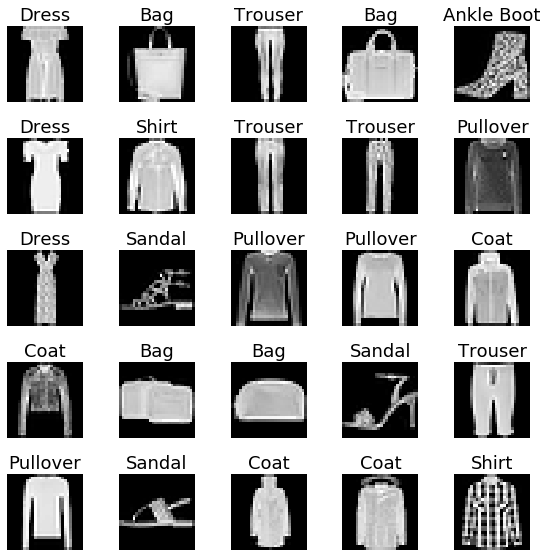

In [5]:
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
              5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}
columns = 5
rows = 5
fig = plt.figure(figsize=(8, 8))

for i in range(1, columns * rows+1):
    data_idx = np.random.randint(len(X_train))
    img = X_train[data_idx].reshape([28, 28])
    label = labels_map[y_train[data_idx]]

    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Building Neural network.
In this section, we'll build the Multi Layer Perceptron (MLP for short) with 2 Dense Layers. MLP, also called Artificial Neural Network, consists of several fully-connected layers. We can add activation function(sigmoid, ReLU or Softmax) for each layer. We can also apply advanced techniques like weight initialization, Dropout or Batch Normalization. Here, we will build 2 Dense layers in Sequential model.

In [13]:
# Build Sequential Model
model = tf.keras.Sequential(name='nn')

model.add(tf.keras.layers.Dense(256, input_shape=(28*28, )))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

We need to figure some points.

- In the input layer, we implemented Dense layer with 256 nodes, and it accepts 28x28-shaped(or 764) input. Since the shape of image is 28x28, and 1D array converted from 2d array will enter here. So we need to define `input_shape` here. Note that, `input_shape` argument have to be a tuple type.
- We added Batch Normalization. Batch Normalization can reduce the effect of Internal Covariate Shift. And it would maintain the information distribution to be normal distribution.
- Here, we added ReLU activation function. We can also add this as an argument of layers.
- Since this task is a sort of multi-class classification, Softmax activation function is added at the end of the output layer.

We can get summary of this model. From the summary, we can check how many layers implement this model, and how many parameters in this model, etc.

In [14]:
model.summary()

Model: "nn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               200960    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 204,554
Trainable params: 204,042
Non-trainable params: 512
_________________________________________________________________


### Model compile
we're almost at the end. Here, we need to compile the model to train. Before compiling, it is required to define loss function and optimizer. As you can see in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/losses), there are lots of loss functions predefined. In this task, we need to classify the label, so our loss function may be categorical crossentropy. But keep in mind that, if your label is sort of one-hot encoding, you need to use `categorical_crossentropy`. Since our label is just integer, meaning its label index, our loss function may be `SparseCategoricalCrossentropy`.

And mainly-used optimizer is Adam with 0.01 learning rate.

In [15]:
# Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Model fit
At last, we can train the model with `model.fit`. Here, we can also define batch size, and epochs, and steps.

In [16]:
model.fit(train_ds, batch_size=128, steps_per_epoch=len(X_train)/128, epochs=10)

Epoch 1/10
469/468 [==============================] - 1s 1ms/step - loss: 0.4541 - accuracy: 0.8366
Epoch 2/10
469/468 [==============================] - 1s 1ms/step - loss: 0.3444 - accuracy: 0.8747
Epoch 3/10
469/468 [==============================] - 1s 1ms/step - loss: 0.3058 - accuracy: 0.8874
Epoch 4/10
469/468 [==============================] - 1s 1ms/step - loss: 0.2822 - accuracy: 0.8959
Epoch 5/10
469/468 [==============================] - 1s 1ms/step - loss: 0.2680 - accuracy: 0.8996
Epoch 6/10
469/468 [==============================] - 1s 1ms/step - loss: 0.2474 - accuracy: 0.9092
Epoch 7/10
469/468 [==============================] - 1s 1ms/step - loss: 0.2385 - accuracy: 0.9116
Epoch 8/10
469/468 [==============================] - 1s 1ms/step - loss: 0.2219 - accuracy: 0.9186
Epoch 9/10
469/468 [==============================] - 1s 1ms/step - loss: 0.2104 - accuracy: 0.9222
Epoch 10/10
469/468 [==============================] - 1s 1ms/step - loss: 0.2002 - accuracy: 0.9249

### Evaluation
We have the model with trained weight. So we can evaluate our model performance with test data. Since test dataset is unseen data from model, so its accuracy and loss may be lower than training one.

In [17]:
loss, acc = model.evaluate(test_ds, steps=len(X_test)/128)
print('test loss is {}'.format(loss))
print('test accuracy is {}'.format(acc))

79/78 [==============================] - 0s 987us/step - loss: 0.4087 - accuracy: 0.8724
test loss is 0.408719003200531
test accuracy is 0.8723999857902527


Also, we can visualize its performance. It'll also visualize true or false of label classification. 

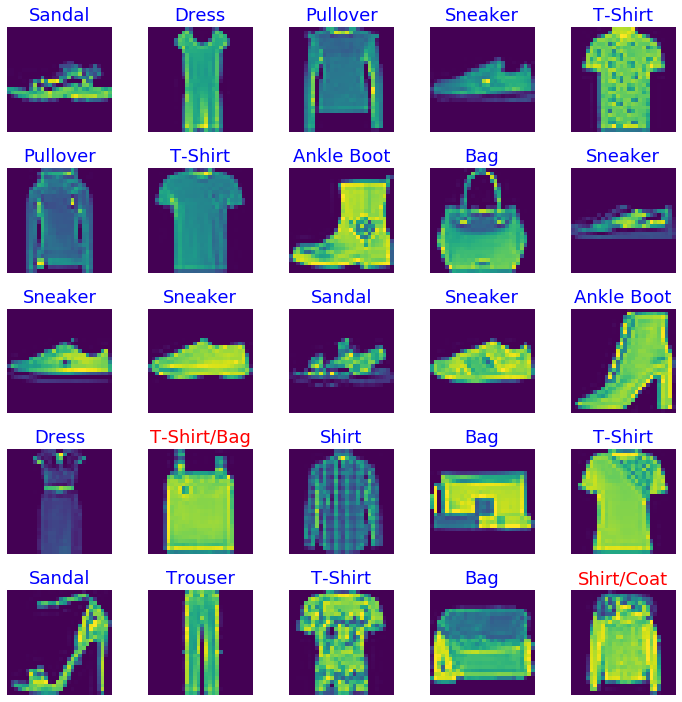

In [20]:
test_batch_size = 25
batch_index = np.random.choice(len(X_test), size=test_batch_size, replace=False)

batch_xs = X_test[batch_index]
batch_ys = y_test[batch_index]
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(batch_xs, batch_ys, y_pred_)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred) == py:
        p.set_title("{}".format(labels_map[py]), color='blue')
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred)],
                               labels_map[py]), color='red')
    p.imshow(px.reshape(28, 28))
    p.axis('off')
plt.tight_layout()

At last, we implement the Multi layer perceptron for image classification. There are some incorrect prediction. But we can improve your model with hyperparameter tuning (the number of epoch, the number of layers, input nodes, learning rate, etc..)

## Summary
In this post, we implemented the neural network for Fashion-MNIST. Through this process, we preprocess the dataset and generate the input pipeline. Then add the layers in sequential model. After that, we defined loss function and optimizers for training. 

Thanks to the tensorflow-keras, we can easily train the model and evalute its performance.